In [ ]:
# SPAM EMAIL DETECTION NOTEBOOK: DATA QC, FEATURE ENGINEERING, EDA & MODELING

# SECTION 1: IMPORTS AND DATA LOADING
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Sklearn & NLP libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
)
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk


In [ ]:
from google.colab import files
uploaded = files.upload()

try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    nltk.download('vader_lexicon')

# Load data
df = pd.read_csv('email_classification_dataset.csv')


Saving email_classification_dataset.csv to email_classification_dataset (3).csv


In [ ]:
# SECTION 2: DATA QUALITY CHECK
def basic_data_quality_check(df):
    print("== DATA QUALITY CHECK ==")
    print(f"Total records: {len(df)}")
    print(f"Total features: {df.shape[1]}")
    print("\nMissing values by column:")
    print(df.isnull().sum())
    print("\nData types:")
    print(df.dtypes)
    print("\nLabel distribution (%):")
    print(df['label'].value_counts(normalize=True) * 100)
    print(f"\nDuplicates: {df.duplicated().sum()}")

basic_data_quality_check(df)

== DATA QUALITY CHECK ==
Total records: 10000
Total features: 3

Missing values by column:
id       0
email    0
label    0
dtype: int64

Data types:
id        int64
email    object
label    object
dtype: object

Label distribution (%):
label
ham     85.0
spam    15.0
Name: proportion, dtype: float64

Duplicates: 0


In [ ]:
# SECTION 3: FEATURE ENGINEERING
def extract_email_features(email_text):
    """
    Extract sender domain, subject, body, and derive numeric & boolean features.
    """
    if pd.isna(email_text):
        return {
            'sender_domain':'','subject':'','body':'',
            'email_length':0,'subject_length':0,'body_length':0,
            'num_links':0,'has_urgency_words':False,
            'has_financial_words':False,'num_caps_words':0,'sentiment':0.0
        }
    # Sender domain
    sender_match = re.search(r'From:\s*\S+@(\S+)', email_text)
    sender_domain = sender_match.group(1) if sender_match else ''
    # Subject line
    subject_match = re.search(r'Subject:\s*(.+?)(?:\n|$)', email_text)
    subject = subject_match.group(1).strip() if subject_match else ''
    # Body text
    body_match = re.search(r'Subject:.*?\n\s*(.*)', email_text, re.DOTALL)
    body = body_match.group(1).strip() if body_match else email_text
    # Lengths
    email_length = len(email_text)
    subject_length = len(subject)
    body_length = len(body)
    # Links count
    num_links = len(re.findall(r'http[s]?://|www\.|\[link', email_text, re.IGNORECASE))
    # Urgency & financial flags
    urgency_words = ['urgent','immediately','asap','expire','deadline','limited time','act now']
    has_urgency = any(w in email_text.lower() for w in urgency_words)
    financial_words = ['payment','invoice','billing','account','credit','bank','money','$']
    has_financial = any(w in email_text.lower() for w in financial_words)
    # All-caps word count
    caps_words = re.findall(r'\b[A-Z]{2,}\b', email_text)
    num_caps = len(caps_words)
    # Sentiment score
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(email_text)['compound']
    return {
        'sender_domain':sender_domain,'subject':subject,'body':body,
        'email_length':email_length,'subject_length':subject_length,
        'body_length':body_length,'num_links':num_links,
        'has_urgency_words':has_urgency,'has_financial_words':has_financial,
        'num_caps_words':num_caps,'sentiment':sentiment
    }

def feature_engineering(df):
    features = df['email'].apply(extract_email_features).apply(pd.Series)
    enhanced = pd.concat([df, features], axis=1)
    return enhanced

enhanced_df = feature_engineering(df)
enhanced_df.head()

,id,email,label,sender_domain,subject,body,email_length,subject_length,body_length,num_links,has_urgency_words,has_financial_words,num_caps_words,sentiment
0,2685,From: support@legitcompany.com\nSubject: Regar...,ham,legitcompany.com,Regarding Your Recent Inquiry,Thank you for reaching out regarding [your inq...,253,29,182,0,False,False,0,0.7506
1,5857,From: noreply@softwareupdates.com\nSubject: We...,ham,softwareupdates.com,Weekly Newsletter - Latest Updates,Please find attached your invoice for the serv...,290,34,211,0,False,True,1,0.7269
2,2399,From: noreply@softwareupdates.com\nSubject: Im...,ham,softwareupdates.com,Important: Software Update Notification,Thank you for your order #6789. Your items wil...,269,39,185,1,False,False,0,0.8807
3,3244,From: info@customerservice.co\nSubject: Team S...,ham,customerservice.co,Team Stand-up at 10 AM,Please find attached your invoice for the serv...,274,22,211,0,False,True,2,0.7269
4,2844,From: info@customerservice.co\nSubject: Team S...,ham,customerservice.co,Team Stand-up at 10 AM,Here's your weekly dose of news and updates fr...,241,22,178,1,False,False,1,0.4767


In [ ]:
#TEXT PREPROCESSING & REPRESENTATION
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')


def preprocess_text(text):
    """Basic text preprocessing pipeline"""
    if not isinstance(text, str):
        return ""

    # Lowercasing
    text = text.lower()

    # Removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize
    tokens = word_tokenize(text)

    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# Applying to email body
enhanced_df['processed_body'] = enhanced_df['body'].apply(preprocess_text)

# TF-IDF
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
tfidf_matrix = tfidf.fit_transform(enhanced_df['processed_body'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

print("\nTop TF-IDF Features:")
print(tfidf_df.sum().sort_values(ascending=False).head(20))

print("\nText preprocessing and representation completed. Added:")
print(f"- TF-IDF features: {tfidf_df.shape[1]} dimensions")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



Top TF-IDF Features:
please      444.027130
name        410.701840
link        405.139380
update      395.469097
survey      389.100943
team        345.070278
software    343.374639
thank       337.284413
best        299.957518
order       296.404224
topic       278.771011
blog        278.771011
due         268.540339
let         265.327865
recent      259.529911
take        259.400629
feedback    259.400629
everyone    247.855622
reminder    245.295895
project     245.295895
dtype: float64

Text preprocessing and representation completed. Added:
- TF-IDF features: 475 dimensions


== BASIC STATISTICS ==
email_length: mean=246.8, median=248.0, std=38.4
subject_length: mean=31.8, median=29.0, std=6.7
body_length: mean=173.9, median=178.0, std=40.6
num_links: mean=0.6, median=1.0, std=0.5
num_caps_words: mean=0.4, median=0.0, std=0.5
sentiment: mean=0.7, median=0.8, std=0.2
has_urgency_words: 6.9% True
has_financial_words: 32.1% True

Top sender domains:
sender_domain
softwareupdates.com      915
homemail.net             881
personalmail.net         875
info.org                 867
billingcorp.com          865
projectmanagement.com    862
example.com              843
retailfeedback.com       812
legitcompany.com         800
customerservice.co       780
Name: count, dtype: int64


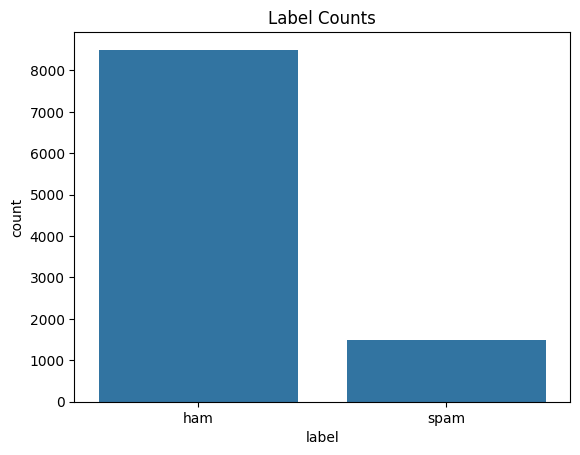

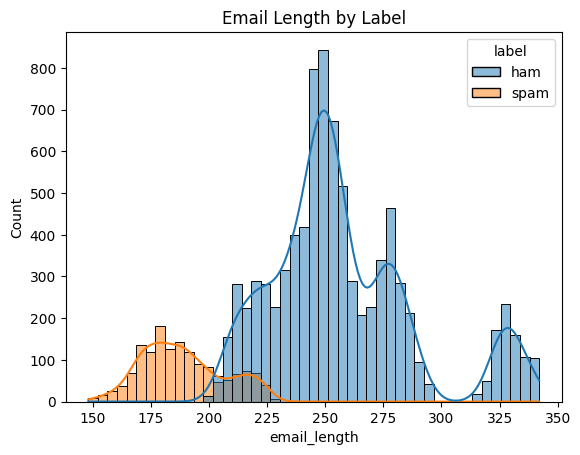

In [ ]:
# SECTION 4: EXPLORATORY DATA ANALYSIS

def basic_statistics_analysis(df):
    print("== BASIC STATISTICS ==")
    nums = ['email_length','subject_length','body_length','num_links','num_caps_words','sentiment']
    for f in nums:
        print(f"{f}: mean={df[f].mean():.1f}, median={df[f].median():.1f}, std={df[f].std():.1f}")
    bools = ['has_urgency_words','has_financial_words']
    for f in bools:
        print(f"{f}: {df[f].mean()*100:.1f}% True")
    print("\nTop sender domains:")
    print(df['sender_domain'].value_counts().head(10))

basic_statistics_analysis(enhanced_df)

# Visuals
plt.figure();
sns.countplot(data=enhanced_df, x='label');
plt.title('Label Counts');
plt.show()

plt.figure();
sns.histplot(data=enhanced_df, x='email_length', hue='label', kde=True);
plt.title('Email Length by Label');
plt.show()

In [ ]:
# SECTION 5: COMPARISON FUNCTIONS

def compare_spam_ham_features(df):
    print("== SPAM vs HAM DETAILED ==")
    spam, ham = df[df.label=='spam'], df[df.label=='ham']
    for f in ['email_length','num_links','num_caps_words','sentiment']:
        print(f"{f}: Spam={spam[f].mean():.1f}, Ham={ham[f].mean():.1f}")
def analyze_sender_domains(df):
    print("== DOMAIN ANALYSIS ==")
    for label in ['spam','ham']:
        top = df[df.label==label]['sender_domain'].value_counts().head(5)
        print(f"Top domains for {label}:\n{top}\n")

compare_spam_ham_features(enhanced_df)
analyze_sender_domains(enhanced_df)

== SPAM vs HAM DETAILED ==
email_length: Spam=188.6, Ham=257.1
num_links: Spam=0.9, Ham=0.5
num_caps_words: Spam=0.1, Ham=0.4
sentiment: Spam=0.4, Ham=0.8
== DOMAIN ANALYSIS ==
Top domains for spam:
sender_domain
unclaimed-funds.co    161
winner-prize.net      161
media-boost.online    157
alert-system.ru       155
easy-cash.top         154
Name: count, dtype: int64

Top domains for ham:
sender_domain
softwareupdates.com    915
homemail.net           881
personalmail.net       875
info.org               867
billingcorp.com        865
Name: count, dtype: int64



In [ ]:
# SECTION 6: MODELING

# Feature selection
features = ['email_length','subject_length','body_length','num_links',
            'has_urgency_words','has_financial_words','num_caps_words','sentiment']
X = enhanced_df[features]
y = enhanced_df['label'].map({'ham':0,'spam':1})
# Split & scale
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=42,test_size=0.2)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Train & evaluate
models = { 'NB':GaussianNB(), 'LR':LogisticRegression(max_iter=1000), 'RF':RandomForestClassifier(n_estimators=100,random_state=42) }
results, preds = [], {}
for name, m in models.items():
    m.fit(X_train,y_train)
    p = m.predict(X_test)
    preds[name]=p
    results.append({
        'Model':name,
        'Accuracy':accuracy_score(y_test,p),
        'Precision':precision_score(y_test,p),
        'Recall':recall_score(y_test,p),
        'F1':f1_score(y_test,p),
        'ROC AUC':roc_auc_score(y_test,m.predict_proba(X_test)[:,1])
    })
df_res = pd.DataFrame(results)
display(df_res)

,Model,Accuracy,Precision,Recall,F1,ROC AUC
0,NB,0.9505,1.0,0.67,0.802395,1.0
1,LR,1.0000,1.0,1.00,1.000000,1.0
2,RF,1.0000,1.0,1.00,1.000000,1.0


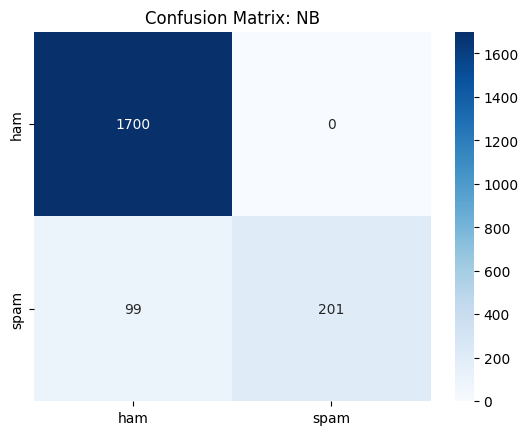

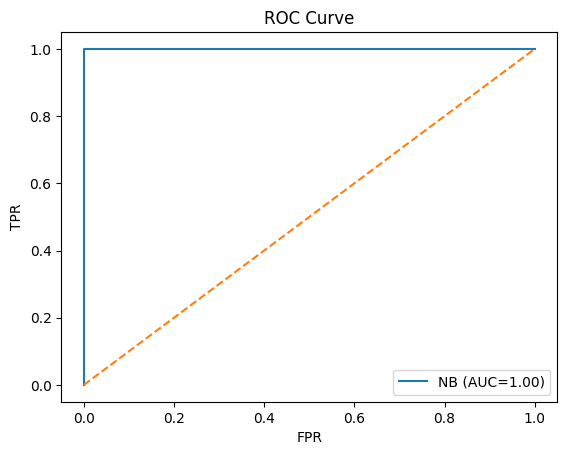

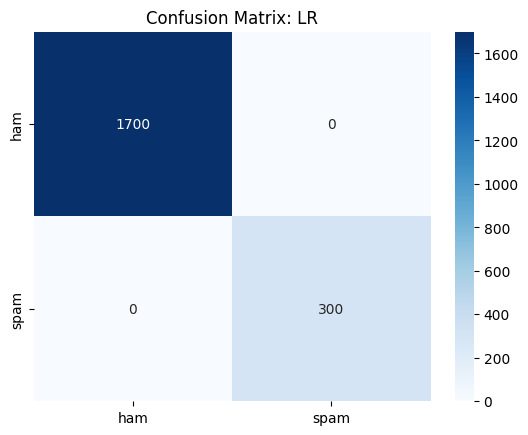

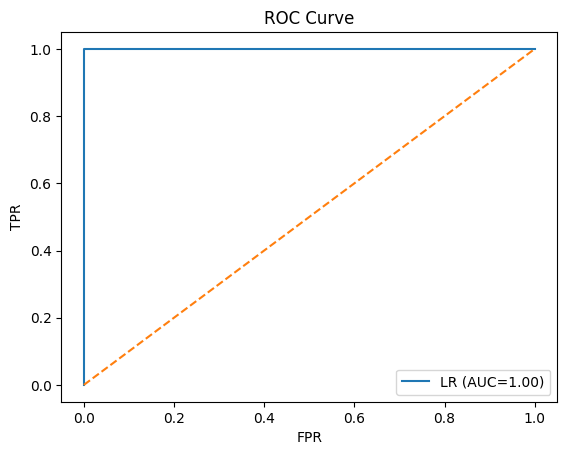

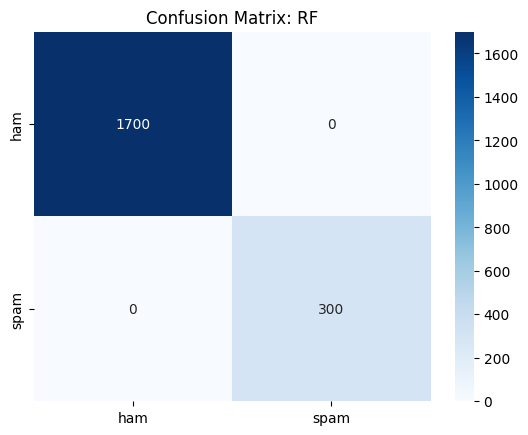

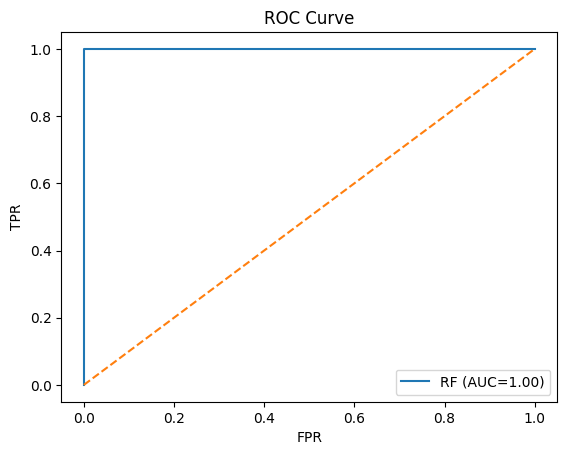

In [ ]:
# Confusion matrices & ROC curves
for name,p in preds.items():
    plt.figure();
    sns.heatmap(confusion_matrix(y_test,p),annot=True,fmt='d',cmap='Blues',
                xticklabels=['ham','spam'],yticklabels=['ham','spam'])
    plt.title(f'Confusion Matrix: {name}')
    plt.show()
    fpr,tpr,_ = roc_curve(y_test,models[name].predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr,tpr,label=f'{name} (AUC={auc(fpr,tpr):.2f})')
    plt.plot([0,1],[0,1],'--')
    plt.title('ROC Curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.show()


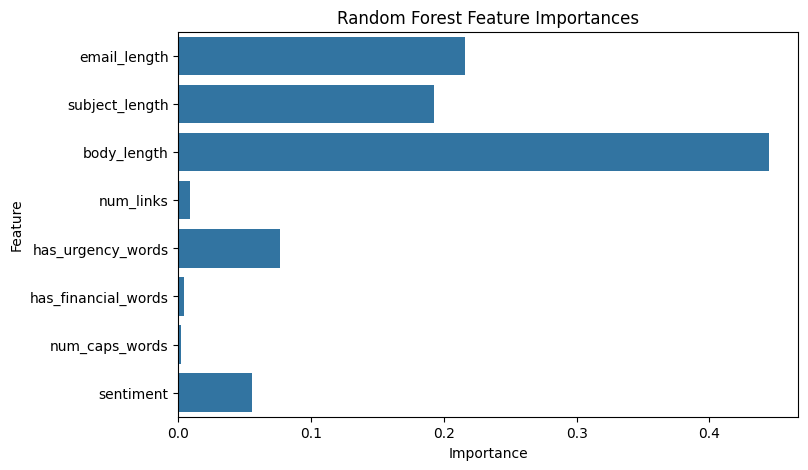

In [ ]:
# SECTION 7: FEATURE IMPORTANCE & ADDITIONAL RELATIONSHIPS
# 7.1 Feature importance from Random Forest
rf = models['RF']
importances = rf.feature_importances_
feat_names = features
plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=feat_names)
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

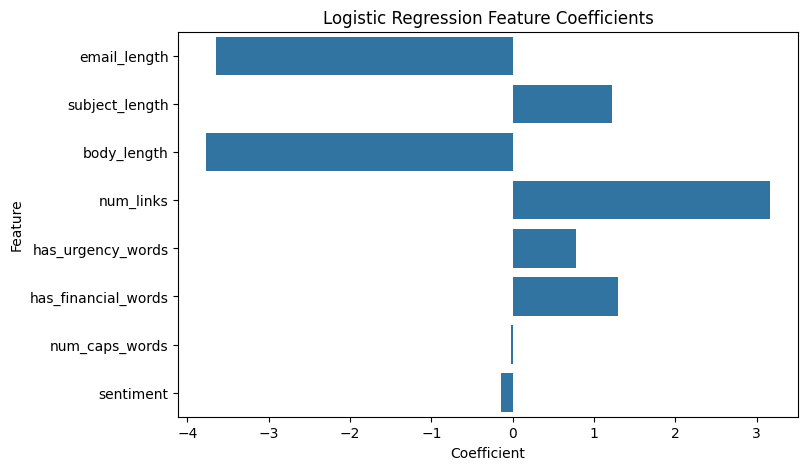

In [ ]:
# 7.2 Logistic Regression coefficients
lr = models['LR']
coef = lr.coef_[0]
plt.figure(figsize=(8,5))
sns.barplot(x=coef, y=feat_names)
plt.title('Logistic Regression Feature Coefficients')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.show()

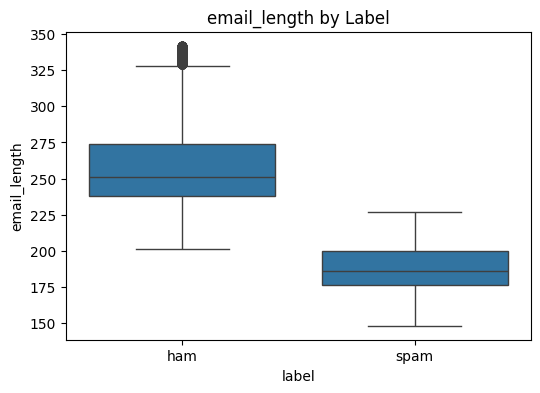

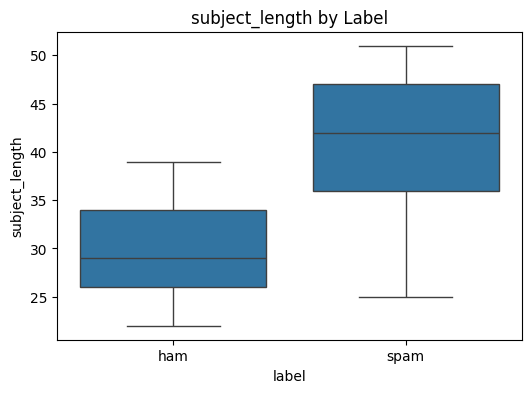

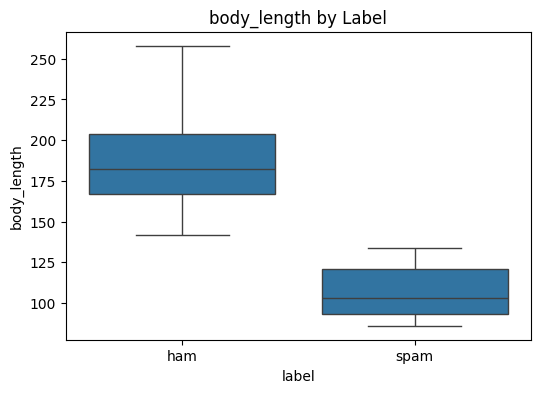

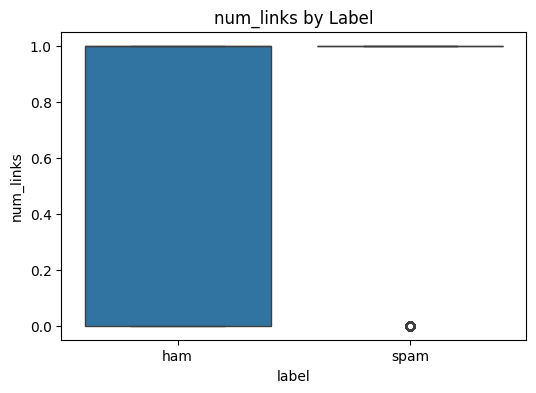

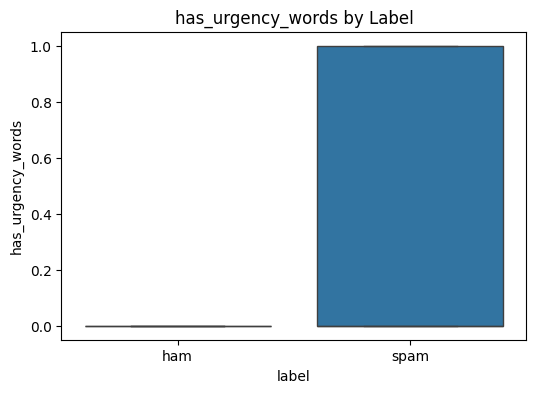

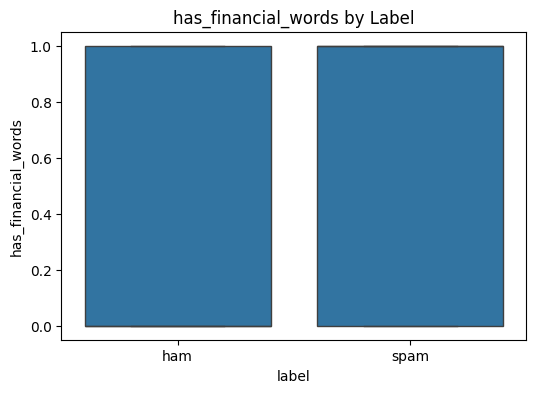

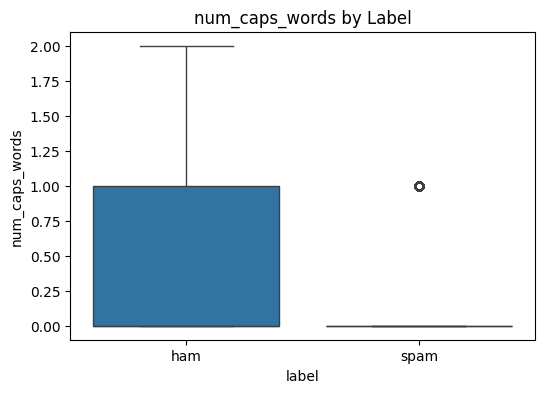

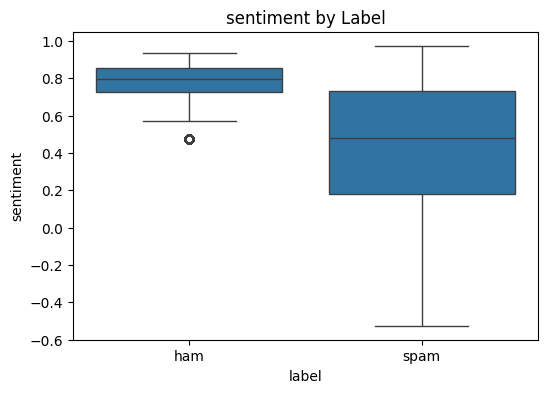

In [ ]:
# 7.3 Boxplots of each feature by label
for f in features:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=enhanced_df, x='label', y=f)
    plt.title(f'{f} by Label')
    plt.show()
